# ATLAS Open Event Generation

ATLAS has released a significant amount of [event generator output](https://opendata.atlas.cern/docs/data/for_research/evgen_data) as open data, in HEPMC2 format. This notebook shows a simple example of how to work with those open data.

## Initialization

We'll start by installing a couple of key packages using `pip`:
* [atlasopenmagic](https://opendata.atlas.cern/docs/atlasopenmagic) provides convenient access to metadata and file locations
* [pyhepmc](https://scikit-hep.org/pyhepmc/) provides convenient ways to play with HEPMC files
* [graphviz](https://pypi.org/project/graphviz/) provides cool visualization interfaces for the events

In [ ]:
%pip install atlasopenmagic pyhepmc graphviz

## Finding and downloading a file to work with

We'll start from atlasopenmagic and set it up to load the open event generation data.

In [ ]:
import atlasopenmagic as atom
atom.set_release('2025r-evgen')

Let's grab a file to play with from one of our open generation datasets. You can pick any dataset from those listed on the [Open Data Portal](https://opendata.cern/record/160000).

In [ ]:
# We'll print all the metadata from the sample (cross section, k-factor, etc)
print(atom.get_metadata('301000'))
# Get the URLs for the files in the dataset. We disable caching because we are
# going to download the files ourselves, by hand
my_urls = atom.get_urls('301000', protocol='https', cache=False)
print(f'Will test with file {my_urls[0]}')

Now let's download that file locally. The files are about 500 MB, which takes about a minute to get to the node most of the time.

In [ ]:
# Pull down the entire file using urllib's request functionality
import urllib.request
(local_filename,headers) = urllib.request.urlretrieve(my_urls[0])
# Use tarfile to get the HEPMC file out of the tar.gz file
import tarfile
with tarfile.open(local_filename, mode="r:gz") as tar_file:
    # There should be only one member - our hepmc file
    hepmc_file = tar_file.getmembers()[0]
    # Extract it!
    tar_file.extract(hepmc_file, filter='data')
print(f'Extracted {hepmc_file.name} from the tarfile')

## Using pyhepmc to inspect the events

First we'll do something very simple: **open the file and print the first event
in text form**. These text-form events are *very long*, but with some practice
they can be "easy" to read. A vertex (Vtx) represents a single interaction
in a tree-like structure, and each vertex has a list of particles that are
input ("I") and output ("O"). Every vertex, and every particle, has a status
that says something about how it was produced or what it means. For example,
particles with `status==1` are "stable" and will enter the detector.

In [ ]:
import pyhepmc
# We'll also import graphviz for visualization
import graphviz
# Open the file itself
my_hepmc = pyhepmc.open(hepmc_file.name)
# Read the first event out of the file
my_first_event = my_hepmc.read()
# Using 'print' prints the event in ASCII format
print(my_first_event)

## Visualize events with pyhepmc and graphviz

All you have to do is have jupyter try to display the event, and with graphviz it
will display a graph. Note that colab requires some effort to get the graph to
display properly with graphviz.

This is a huge graph! Feel free to play with the visualization following some of the
[pyhepmc visualization tutorial](https://scikit-hep.org/pyhepmc/examples/basics.html).

In [6]:
# Use graphviz to visualize the graph
my_first_event

<GenEvent momentum_unit=0, length_unit=0, event_number=1, particles=861, vertices=516, run_info=GenRunInfo(tools=[], weight_names=['0'], attributes={})>

## Examining the particles in the event

Let's look at just the first 15 particles.

We'll be able to see the incoming protons, as well as various particles involved in
the collision. Notice that the two incoming protons in the collision are *not*
necessarily the first and second particles in the event! Any analysis of these
events always takes a bit of care, because the event records might not look the way
you would naively expect. It's always good to check your assumptions carefully.

In [7]:
# Print the first 15 particles
my_first_event.particles[:15]

[GenParticle(FourVector(0, 0, 6.5e+06, 6.5e+06), mass=938.27, pid=2212, status=4),
 GenParticle(FourVector(611, -2.32e+03, 4.39e+05, 4.39e+05), mass=0, pid=21, status=61),
 GenParticle(FourVector(278, 122, 3.14e+04, 3.14e+04), mass=0, pid=21, status=61),
 GenParticle(FourVector(911, 915, 1.26e+05, 1.26e+05), mass=0, pid=21, status=61),
 GenParticle(FourVector(1.39e+03, 156, 5.41e+05, 5.41e+05), mass=0, pid=21, status=61),
 GenParticle(FourVector(4.36, 1.06e+03, 1.56e+03, 1.89e+03), mass=0, pid=2, status=61),
 GenParticle(FourVector(-792, 616, 3.01e+03, 3.18e+03), mass=0, pid=21, status=61),
 GenParticle(FourVector(-328, -403, 3.85e+06, 3.85e+06), mass=771.33, pid=2203, status=63),
 GenParticle(FourVector(-696, -42.9, 1.4e+06, 1.4e+06), mass=330, pid=1, status=63),
 GenParticle(FourVector(-1.38e+03, -105, 1.06e+05, 1.06e+05), mass=330, pid=-2, status=63),
 GenParticle(FourVector(0, 0, -6.5e+06, 6.5e+06), mass=938.27, pid=2212, status=4),
 GenParticle(FourVector(-1.13e+03, 594, -2.49e+06

## Building histograms from the HEPMC record

Now we'll make a couple of simple histograms by looping over all the events in the file and calculating a few event properties. We'll use the `hist` library, which is a convenient python library for histogramming.

These are di-electron Drell-Yan events, which means we should expect them to almost always have a high-momentum electron and a high-momentum positron. We will look at the mass and momentum of that pair of particles in this example. You can read from the dataset name that we expect the mass to be between 120 and 180 GeV. Notice that we pick out the `status==1` particles, which are the ones that are stable. The status code allows a physicist to pick particles at different stages of the calculation that was used to produce the event.

Here we'll also do a quick conversion, because the particle energies in the file are stored in `MeV`, and we'll draw them in `GeV`.

In [8]:
import hist # Useful library for histogramming
# We will make histograms of the mass and pT of the Drell-Yan events
m_hist = hist.Hist(hist.axis.Regular(40, 120, 180, label="DY mass [GeV]"))
pt_hist = hist.Hist(hist.axis.Regular(40, 0, 200, label="DY p_{T} [GeV]"))
# Open the HEPMC file
with pyhepmc.open(hepmc_file.name) as my_hepmc_input:
    # And loop through all the events
    for event in my_hepmc_input:
        # Because these are Drell-Yan di-electron events, we'll look for the highest transverse-momentum electrons
        electrons = [p for p in sorted(event.particles, key=lambda p:p.momentum.pt()) if abs(p.pid) == 11 and p.status==1]
        # In case we didn't find two electrons that are stable, just keep going
        if len(electrons)<2:
            continue
        # Fill in the histograms with the mass and momentum (with the right units!)
        m_hist.fill((electrons[0].momentum+electrons[1].momentum).m()/1000.)
        pt_hist.fill((electrons[0].momentum+electrons[1].momentum).pt()/1000.)

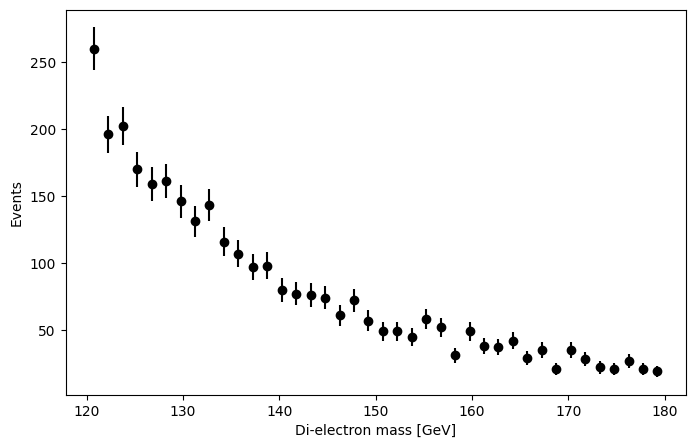

In [9]:
# Now we can draw the histograms using matplotlib and numpy
import matplotlib.pyplot as plt
import numpy as np
# Create a canvas that we'll draw the plot on
fig, ax = plt.subplots(figsize=(8, 5))
# Convert the hist histogram into numpy arrays
y, bin_edges = m_hist.to_numpy()
# Calculate a statistical uncertainty on the points
yerr = np.sqrt(y)
# Slightly awkward - convert from bin edges, which is what hist gives us, into bin centers, which is what matplotlib wants
x = [ (bin_edges[n]+bin_edges[n+1])/2. for n in range(len(bin_edges)-1) ]
# Now we can create the actual plot of our data
ax.errorbar(x=x, y=y, yerr=yerr,
                    fmt='ko', # 'k' means black and 'o' is for circles
                    label='Data')
# Set some labels to make it more clear what the plot shows
ax.set_xlabel("Di-electron mass [GeV]")
ax.set_ylabel("Events")
# And finally, do the drawing
plt.show()

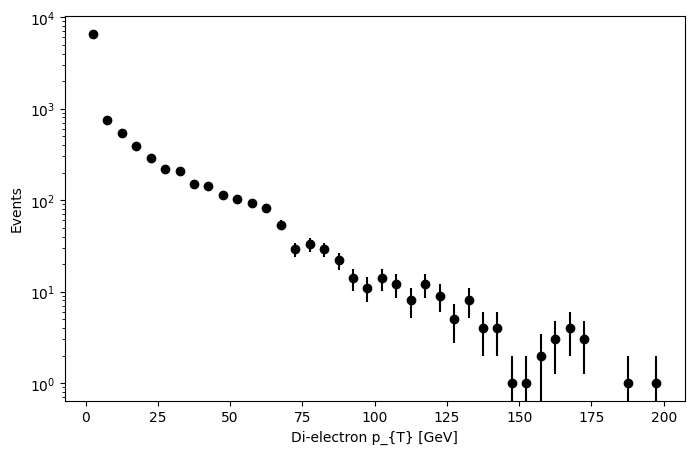

In [10]:
# And we can draw the transverse momentum plot as well
# This follows the same structure as in the previous cell
fig, ax = plt.subplots(figsize=(8, 5))
y, bin_edges = pt_hist.to_numpy()
yerr = np.sqrt(y)
x = [ (bin_edges[n]+bin_edges[n+1])/2. for n in range(len(bin_edges)-1) ]
ax.errorbar(x=x, y=y, yerr=yerr,
                    fmt='ko', # 'k' means black and 'o' is for circles
                    label='Data')
ax.set_xlabel("Di-electron p_{T} [GeV]")
ax.set_ylabel("Events")
# We'll use a log y-axis so that the full graph is more visible
ax.set_yscale('log')
plt.show()

Feel free to play yourself and develop your own (more complex) usage for our HEPMC files! If you want to use pyhepmc, there are plenty of [examples available](https://scikit-hep.org/pyhepmc/examples.html).

# Detector Simulation

We can do some simple detector simulation using [Delphes](https://github.com/delphes/delphes) as well. Delphes is a pretty standard parametric detector simulation package used widely in the phenomenology community. The first thing we have to do is install it.

In [11]:
%conda install --channel conda-forge delphes

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.0
    latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - delphes


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.8.3   |       hbd8a1cb_0         151 KB  conda-forge
    certifi-2025.8.3           |     pyhd8ed1ab_0         155 KB  conda-forge
    delphes-3.5.0              |       h9276a11_5         3.3 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.6 MB

The following NEW packages will be INSTALLED:

  delphes            conda-forge/linux-64::delphes-3.5.0-h9276a11_5 

T

Delphes offers some command-line executables that can be used. We will run one of the pre-defined analyses as an example. Of course, more complicated usage is possible!

Notice that we are passing the HEPMC file name through bash magic here.

In [12]:
%%bash -s {hepmc_file.name}
DelphesHepMC2 ${CONDA_PREFIX}/cards/delphes_card_ATLAS.tcl delphes_output.root $1

** INFO: adding module        ParticlePropagator       ParticlePropagator       
** INFO: adding module        Efficiency               ChargedHadronTrackingEfficiency
** INFO: adding module        Efficiency               ElectronTrackingEfficiency
** INFO: adding module        Efficiency               MuonTrackingEfficiency   
** INFO: adding module        MomentumSmearing         ChargedHadronMomentumSmearing
** INFO: adding module        MomentumSmearing         ElectronMomentumSmearing 
** INFO: adding module        MomentumSmearing         MuonMomentumSmearing     
** INFO: adding module        Merger                   TrackMerger              
** INFO: adding module        SimpleCalorimeter        ECal                     
** INFO: adding module        SimpleCalorimeter        HCal                     
** INFO: adding module        PdgCodeFilter            ElectronFilter           
** INFO: adding module        PdgCodeFilter            ChargedHadronFilter      
** INFO: adding m

** [################################################################] (100.00%)


** Exiting...


Now we can examine the output of our Delphes run. It is written into a ROOT file, so just like in our other analyses we can look at it using uproot!

In [13]:
import uproot # for reading .root files
# Get the tree with our data directly from the ROOT file
tree = uproot.open("delphes_output.root:Delphes")
# Just for an example here, we'll print the transverse momenta of the electrons
tree["Electron.PT"].arrays()

<Array [{'Electron.PT': [44.9]}, ..., {...}] type='10000 * {"Electron.PT": ...'>

It's just that easy! From here, we can do anything that's been done from our [analysis notebooks](https://opendata.atlas.cern/docs/category/analysis-notebooks)!